<!-- dom:TITLE: Minimization examples for Machine Learning using gradient descent methods -->
# Esempi di Minimizzazione attraveso la discesa del gradiente 
<!-- Author: -->  
<!-- dom:AUTHOR: Carlo Barbieri at Department of Physics, Università Statale di Milano -->
<!-- Author: -->  

C. Barbieri, $\qquad$ **Dicembre 2024**.


Metodi di *discesa del gradiente* (Gradient Descent) e *discesa stocastica del gradiente* (Stochastic Gradient Descent) in funzioni di molti parametri.

Questo Notebook contiene:

+ Esempi di discesa del granidente con minimizzazione lineare e stocatic gradient descent.

+ Ulteriori discussioni sull'implementazione della velocità di apprendimento in SGD (che vedremo anche a lezione).


### Testi di riferimento

Il materiale discusso in queste lezioni è estratto da: [Aurelien Geron's chapter 4](https://gitlab.com/craolus/MachineLearning-con-applicazioni/-/blob/master/Documenti/Monografie/TensorflowML.pdf) e [Murphy sections 8.3 and 8.5](https://gitlab.com/craolus/MachineLearning-con-applicazioni/-/blob/master/Documenti/Monografie/MachineLearningMurphy.pdf) 



## Ottimizzazione come elemento centrale degli algoritmi di apprendimento automatico

La stragrande maggioranza dei problemi in apprendimento autyomatico parte da un dataset $\mathcal D=\{(y_i,\boldsymbol{x}_i)\}$,
un modello di predizione $f(\boldsymbol{x};\{\theta_j\})$ che dipende da un insieme di parametri $\{\theta_j\}$ ed una funzione di costo $C(\boldsymbol{X},{\vec y}, f(\{\theta_j\}))$ che permette di giudicare la capacità di $f(\boldsymbol{x};\{\theta_j\})$ nello spiegare i campionamenti $\mathcal D$. 
Il modello vine ottimizzato (o '_allenato_') cercando i valori di $\{\theta_j\}$ che minimizzano la funzione di costo. 
Nel caso ideale si vorrebbe si vorrebbe poter ottenere la soluzione in maniera analitica ma questo è quasi mai possibile, quindi è necessario ricorrere a metodi approssomati e/o numerici per trovare il minimo. 



## Metodi basati sulla semplice *discesa lungo il gradiente*

Da questo punto in poi consideriamo una funzione $F(\mathbf{x})$, $\mathbf{x} \equiv (x_1,\cdots,x_n)$, ed il problema di trovare un punto $\mathbf{x}^*$ corrispondente al suo minimo globale.

L'idea di base della discesa lungo il gradiente (in inglese, *gradient descent (GD)* o *steepest descent*) è quella che la funzione $F(\mathbf{x})$ diminuisce più velocemente nel verso opposto al gradiente che in qualunque altra direzione: $-\nabla F(\mathbf{x})$.

Dato $\mathbf{x}_k$ ed un punto successivo
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k)  \,,
$$
<!-- !split  -->
è possibile dimostrare che $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ purchè $\gamma_k > 0$ sia (positivo e) sufficientemente piccolo. Ovvero, per passi piccoli ci si avvicina sempre ad un minimo. In generale, si sceglie un punto iniziale $\mathbf{x}_0$ e si itera più volte l'equazione sopra fino al raggiungimenti di un minimo.

Il parametro $\gamma_k$  controlla al lunghezza di ogni passo e viene chiamato *velocità di apprendimento* (*learnign rate*) in apprendimento automatico.

Va notato che nel caso spefiale di una funzione $F(\mathbf{x})$ convessa esiste un solo minimo e la sequenza $\{\mathbf{x}_k \}_{k=0}$ converge sempre ad esso. Questo non è più vero nel caso di funzioni di costo non convesse ed in molte dimansioni tipiche dei problemi di apprendimento automatico. Quindi è spesso facile trovarsi intrappolati in minimi locali ed in più il risultato dipende dalla scelta del punto di partenza $\mathbf{x}_0$.

Inoltre, il metodo della **discesa del gradiente** è *sensibile alla scelta della velocità di apprendimento* perché la condizione $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ e garantita soltanto per valori di $\gamma_k>0$ sufficientmente piccoli. Un aspetto critico è determinarne il valore: se 
l'apprendimento è troppo lento l'algoritmo potrebbe richiedere tempi proibitivamente lunghi per convergere, se invece è troppo veloce si può avere
un comportamento erratico. (Vedremo più sotto che alcuni di questi problemi sono alleviati da un approccio stocastico).


### Primo esempio di discesa del gradiente 

Qui sotto riportiamo un esempio di implementzione in python della discesa del  gradiente con una minimizzazione rettilinea (in inglese, '*line minimization*' o '_line search_'). L'approccio consiste nel implemetare la discesa del gradiente secondo

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k),
$$

ma la velocità di apprendimento $\gamma_k$ viene ottimizzata ogni volta per ottenere la riduzione massima possibile della funzione che si vuole minimizzare:

$$
\gamma_k = \underset{\gamma}{\mathrm{arg\,min}} \; F( \mathbf{x}_k - \gamma \nabla F(\mathbf{x}_k) ) \, .
$$

Iniziamo con il generare due metodi python per calcolare una funzione semplice convessa in 2D ed il suo gradiente, la funzione scelta è $F(x,y) = \frac 1 2 x^2 + \frac 5 2 y^2$:


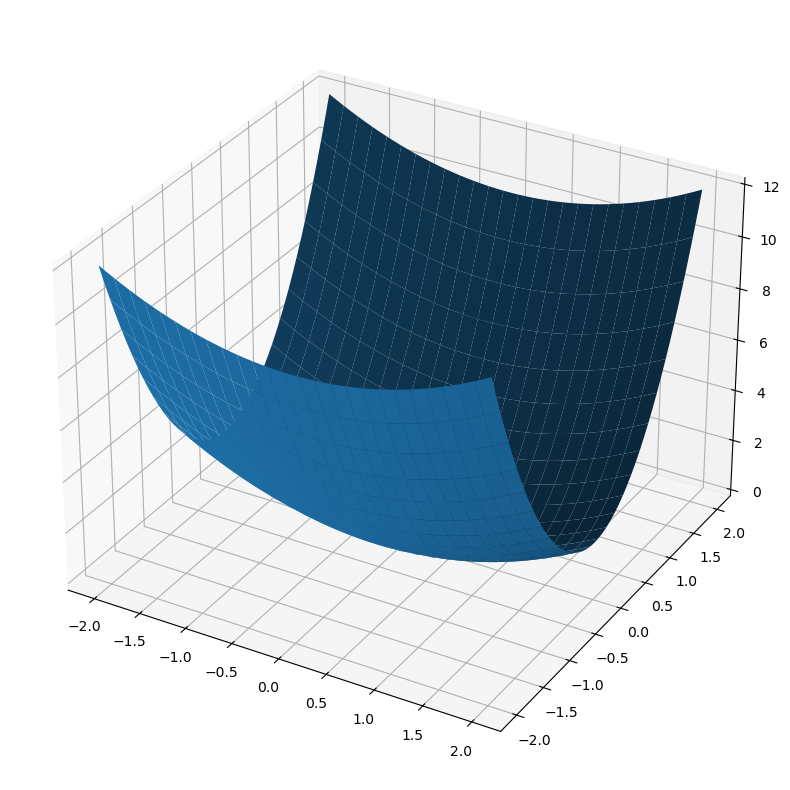

In [14]:
# Assicura che i risultati di matplotlib (le figure) siano mostrati nella cella successiva
%matplotlib inline

#
# Carichiamo le varie librerie:
import numpy as np
import numpy.linalg as la      # componente di numpy per l'algebra lineare (data la riga precedente potremmo invocalro come 'np.linlag' ma 'la' è più breve)
   
import scipy.optimize as sopt  # funzioni di minimizzazione (per la line search)

import matplotlib.pyplot as pt
from mpl_toolkits.mplot3d import axes3d


# Funzione per  F(x) = (1/2) x^2 * (5/2) y^2
# NOTA: qui x è un array in 2 dimensioni!
def f(x):
    return 0.5*x[0]**2 + 2.5*x[1]**2

# Gradiente:  \nabla f(x) = (x, 5y)^T
def df(x):
    return np.array([x[0], 5*x[1]])


# Inizializza la figura ed il tipo di assi
fig = pt.figure(figsize=(14,10))
ax = pt.axes(projection="3d") 

# 'numpy.mgrid' = 'multidimensional grid'
# Qui è usato per generare una griglia in 2D e restituisce array in 2 dimensioni,
# il primo contenente tutti i valori delle x ed il secondo i valori corrispondenti 
# delle y.   -2:2 da i punti iniziali e finale, mentre ':51j' richiede 51 punti (50
# intervalli per ogni direzione.
xmesh, ymesh = np.mgrid[-2:2:51j,-2:2:51j]
#Per vedere gli array:
#  print(xmesh,ymesh)

# Calcola la funzone su ogni punto della griglia
fmesh = f(np.array([xmesh, ymesh]))

# Genera la figura:
ax.plot_surface(xmesh, ymesh, fmesh)

pt.show()

La mappa a livelli della funzione è la seguente:

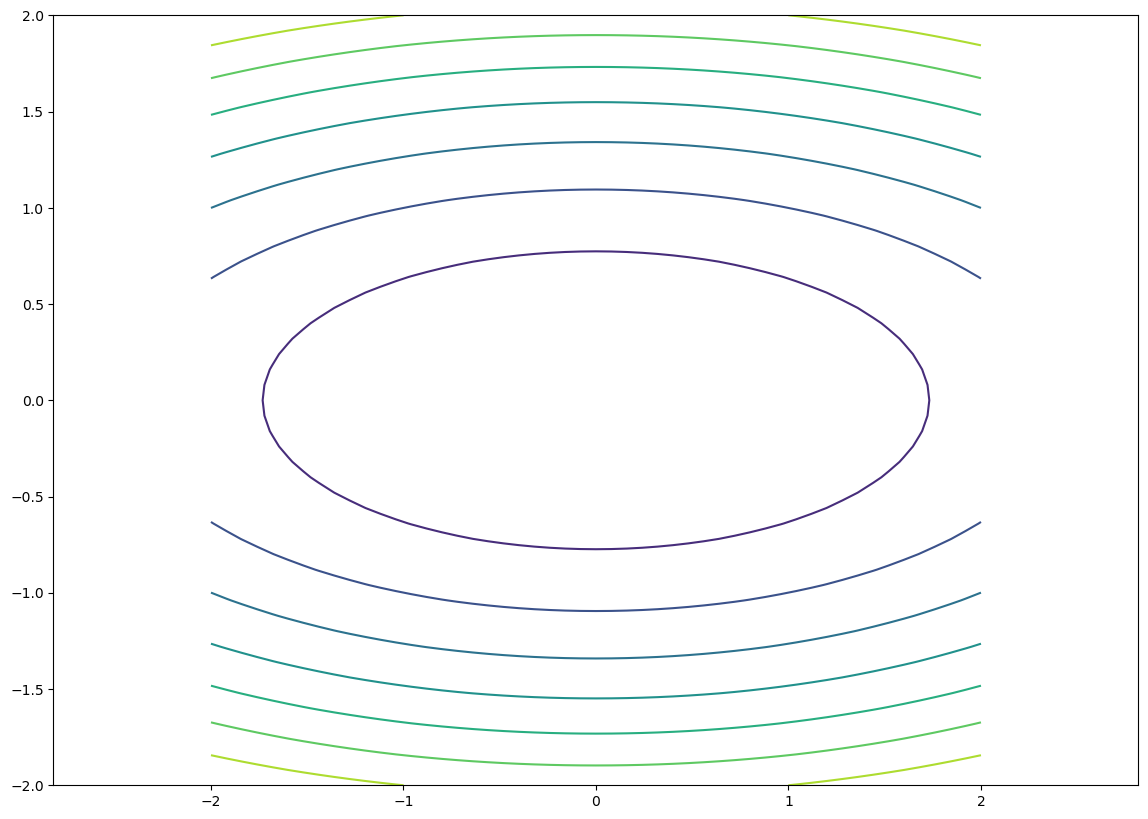

In [15]:
pt.figure(figsize=(14,10))
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh)  # genrate a contour plot

pt.show()

Il mprimo passo è scegliere un punto da cui partire con la minimizzazione, per esempio:

In [16]:

# scelta del punto di partenza per la minimizzazione:
PathToMin = [np.array([1.9, .3])]

print('\nAbbiamo r(re-)inizializzato il percorso di minimizzazione al seguente punto di partenza:')
print(PathToMin) 


Abbiamo r(re-)inizializzato il percorso di minimizzazione al seguente punto di partenza:
[array([1.9, 0.3])]


La casella seguente prende l'ultimo punto della lista 'PathToMin' (all'inizio conterrà solo il puno di partenza) ed effettua una ricerca lungo linea (line search) per generare una nuova approssimazione.  La seconda parte della cella (ri)disegna il grafico a livelli con il percorso di minimizzazione.

Nell'implementzione qui sotto è stato codificato solo un passo, senza le iterazioni necessarie per raggiungere il minimo. Si provi ad eseguire la casella più volte im modo da seguire l'algoritmo passo-passo (oppure si può tornare alla casella precedente per ripartire da capo):


Lultimo punto generato è:
[ 0.03964211 -0.01004267]

Il percorso di minimizzazione finora è:
[[ 1.9         0.3       ]
 [ 1.15074024 -0.29152086]
 [ 0.81855611  0.1292457 ]
 [ 0.49576077 -0.12559273]
 [ 0.35264953  0.0556815 ]
 [ 0.21358316 -0.05410773]
 [ 0.15192812  0.02398865]
 [ 0.09201569 -0.02331064]
 [ 0.06545352  0.01033477]
 [ 0.03964211 -0.01004267]]


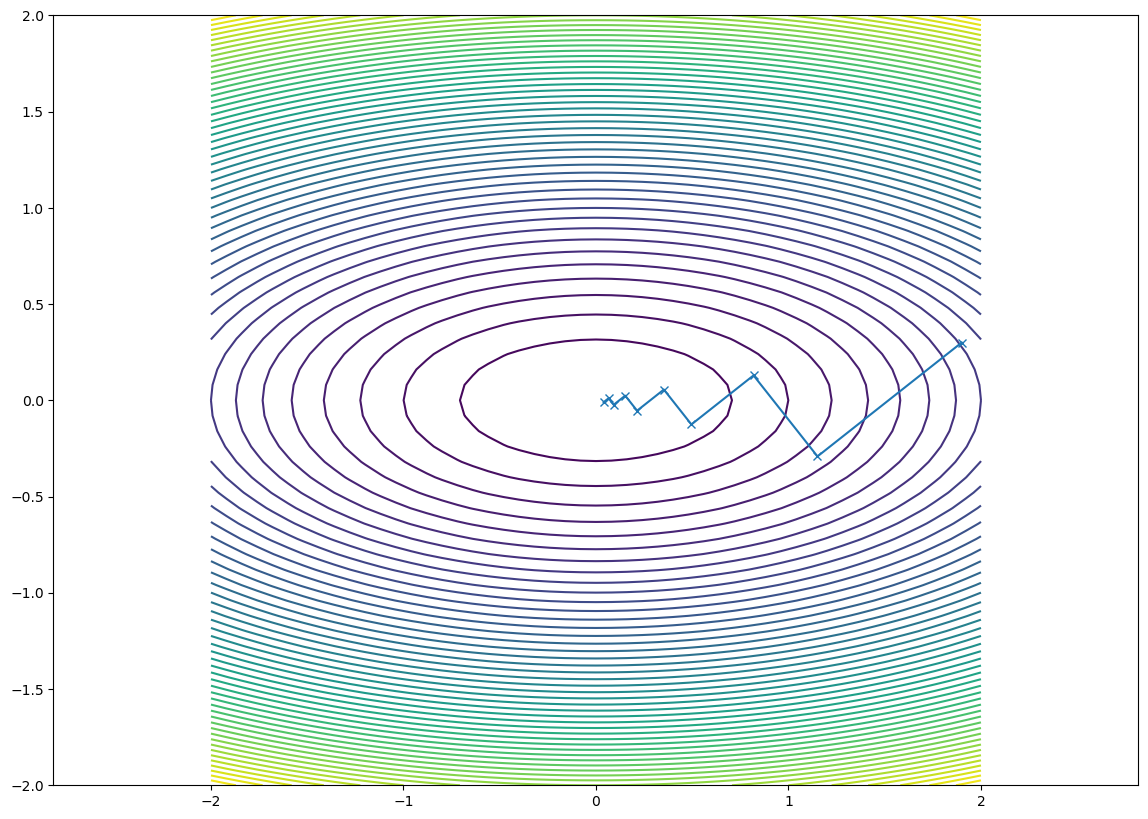

In [25]:
# Definiamo una funzione per calcolare il valore di f(x) (definita sopra) in un punto
# a distanza \alpha * |s| dalla variabile 'x'
# NOTA: Qui alpha è un float mentre  'x' ed il gradiente 's' sono array in 2 dimensioni!
def f1d(gamma):
    return f(x - gamma*g)

# ultim punto memorizzato nel percorso di minimizzazione
x = PathToMin[-1]
g = df(x)

# Il metodo 'scipy.optimize.golden( fn(y) )' trova il valore di 'y' che minimizza
# la funzione fn(). In questo caso la usiamo come trucco per calcolare la velocità
# di apprendimento ottimale lungo il gradiente ('line search'): passiamo la funzione
# 'f1d()' che è definita lungo la linea 'x - gamma * g' e ne chiediamo il minimo
# rispetto a 'gamma'.
gamma_opt = sopt.golden(f1d)

# Genera il prossimo punto del percorso di minimizzazione e lo aggiunge alla lista 'PathToMin'
next_guess = x - gamma_opt * g
PathToMin.append(next_guess)


print('\nL''ultimo punto generato è:')
print(next_guess)

# Genera la figura della mappa a livelli con il percorso
pt.figure(figsize=(14,10))
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh, 50)
it_array = np.array(PathToMin) # qui trasformiamo la lista 'guesses' in un array di punti 2D (il formato richiesto da 'matplotlib').
pt.plot(it_array.T[0], it_array.T[1], "x-")

print('\nIl percorso di minimizzazione finora è:')
print(it_array)

pt.show()

#### Ottimizzazione della celocità di apprendimento

Da uno sviluppo al *secondo ordine* della superficie da minimizzare $F(\mathbf{x})$, e nell'approssimazione di un andamento localmente parabolico, si  vede che il comportamento al variare dell velocità di apprendimento è il seguente:
- $0<\gamma<\gamma^*$: la minimizzazione segue un percorso regolare, tanto piu lento quanto $\gamma$ si avvicina a $0$.
- $\gamma^*<\gamma<2\gamma^*$: si raggiunge un minimo attraverso una sequenza di oscillazioni tanto più ampie quato più grande è $\gamma$.
- $2\gamma^*<\gamma$: L'alrogitmo diverge con un andamento oscillatorio,
dove $\gamma^*$ è il valore ottimale.

Si provi a riptere l'esempio precedente modificando $\gamma$ in modo da ricreare queste situazioni. Per esempio:


In [13]:
next_guess = x - 0.1 * gamma_opt * g

# oppure

next_guess = x - 1.5 * gamma_opt * g

# oppure

next_guess = x - 2.2 * gamma_opt * g


<!-- !split  -->
---


### Applicazione ad una regressione lineare semplice

Qui di seguito vogliamo dimostrare il funzionamento dei metodi di discesa del gradiente (GD) e come possono essere implementati in Python. Per semplicità useremo lo stesso esempio usato nel capitolo 4 del libro di A. Géron. La regressione lineare è un banco di prova molto facile per i metodi di GD perché:

1. Ha una soluzione analitica.

2. Il gradiente può essere calcolato analiticamente.

3. La funzione di costo è convessa e *garantisce* la convergenza della discesa gradiente per velocità di apprendimento non eccessivamente elevate.

Consideriamo una sola carattertistica di input ed un sistema con un comportamento lineare del tipo $y=3x+4$. Per creare il set di dati campioniamo le la caratteristica in modo uniforme nell'intervallo $x\in[0,2]$ (metodo '_numpy.random.rand()_') e aggiungiamo un errore normalmente distribuito, $\cal {N}(0,1)$, campionando le rispettive etichette (metodo '_numpy.random.randn()_'):

In [27]:
Ns=100
x = 2*np.random.rand(Ns,1)
y = 4+3*x+np.random.randn(Ns,1)

Il modello di regressione lineare è dato da:
$$
\hat{y} = f_\boldsymbol{\beta}(x) = \beta_0 + \beta_1 x,
$$


Usando il set di allenamento appena creato, $\mathcal{D}=\{(y_i,x_i): i=1,\ldots,N_S\}$ possiamo definire il vettoredelle etichette, $\vec{y} = (y_1,\cdots,y_{N_S})^T$, i parametri del modello, $\boldsymbol{\beta} = (\beta_0, \beta_1)^T$, e la matrice di design:

$$
\boldsymbol{X} \equiv \begin{pmatrix}
1 & x_1  \\
\vdots & \vdots  \\
1 & x_{N_S} &  \\
\end{pmatrix} \; \in \mathbb{R}^{N_S \times 2} \, .
$$

Il nostro obbiettivo è minimizzare la funzione di costo 
$$
C(\boldsymbol{\beta}) = \frac{1}{N_S}||\boldsymbol{X} \boldsymbol{\beta} \, -\, \vec{y}||_{2}^{2} = \frac{1}{N_S}\sum_{i=1}^{N_S}\left[ (\beta_0 + \beta_1 x_i)^2 - 2 y_i (\beta_0 + \beta_1 x_i) + y_i^2\right]
$$
rispetto a $\boldsymbol{\beta}$. La soluzione esatta è nota: $\boldsymbol{\beta}= (\boldsymbol{X}^T \boldsymbol{X})^{-1} \boldsymbol{X}^T \vec{y}$.


### Codice per la discesa del gradiente (GD) semplice

Per implementare il metodo di GD sono necessarie le **derivate parziali della funzione di costo** rispetto ai parametri del modello, $\partial C(\boldsymbol{\beta}) / \partial \beta_0$ e $\partial C(\boldsymbol{\beta}) / \partial \beta_1$. Il gradiente è dato da:

$$
\nabla_{\boldsymbol{\beta}} C(\boldsymbol{\beta}) = \frac{2}{N_S}\begin{pmatrix} \sum_{i=1}^{N_S} \left(\beta_0+\beta_1x_i-y_i\right) \\
\sum_{i=1}^{N_S}\left( x_i (\beta_0+\beta_1x_i)-y_ix_i\right) \\
\end{pmatrix} = \frac{2}{N_S}\boldsymbol{X}^T(\boldsymbol{X}\boldsymbol{\beta} - \mathbf{y}),
$$

dove $\boldsymbol{X}$ è la matrice di design definita sopra. La matrice Hessiana di $C(\boldsymbol{\beta})$ è data da:

$$
\boldsymbol{H} \equiv \begin{pmatrix}
\frac{\partial^2 C(\boldsymbol{\beta})}{\partial \beta_0^2} & \frac{\partial^2 C(\boldsymbol{\beta})}{\partial \beta_0 \partial \beta_1}  \\
\frac{\partial^2 C(\boldsymbol{\beta})}{\partial \beta_0 \partial \beta_1} & \frac{\partial^2 C(\boldsymbol{\beta})}{\partial \beta_1^2} &  \\
\end{pmatrix} = \frac{2}{N_S}X^T X.
$$

Il fatto che $\boldsymbol{X}^T \boldsymbol{X}$ sia definita positiva implica che $C(\boldsymbol{\beta})$ è una funzione convessa. 
L'algorithmo GD minimizza $C(\boldsymbol{\beta})$ iterando la sequenza:

$$
\boldsymbol{\beta}_{k+1} = \boldsymbol{\beta}_k - \gamma \nabla_\boldsymbol{\beta} C(\boldsymbol{\beta}_k), \ k=0,1,\ldots \,,
$$

dove $\gamma$ è la velocità di apprendimento. Questa procedura richiede soltanto il gradiente e non l'Hessiana. In pratica però gli autovalori di $\boldsymbol{H}$ permettono di stimare la velcità di apprendimento ottimale. Abbiamo visto che è sufficiente scegliere
$$
 \gamma \leq \frac 2 {\lambda_{\rm max}}
$$
per assicurare la convergenza del GD (dove $\lambda_{max}$ è il maggiore degli autovalori di $\boldsymbol{H}$). Inoltre la velocità di apprendimento ottimale nella direzione di maggior curvatura è:
$$
\gamma^* = \frac 1 {\lambda_{\rm max}} \,.
$$
Siccome $\boldsymbol{H}$ non dipende dai parametri, $\boldsymbol{\beta}$, è sufficiente calcolare $\gamma^*$ una volta sola all'inizio del codice.
Tipicamente si può scegliere il punto di partenza $\boldsymbol{\beta}_{k=0}$ in modo casuale e adottare un critertio di convergenza per fermare le iterazioni, per esempio quando 
$||\Delta \boldsymbol{\beta}||=||\gamma^* \nabla_\beta C(\beta_k) || \leq \epsilon = 10^{-8}$ (si noti che questo non è implementato nel codice qui sottto). 

#### Esempio di codice
Dopo aver creato il dataset come descritto sopra, il codice seguente calcola la matrice di design e utilizza varie funzioni di algebra lineare di 'numpy' ('np.linalg.inv' e 'np.linalg.eig') per calcolare l'Hessiana, la velocità di apprendmento e la soluzione esatta. Fatto questo, la minimizzazioe di GD richiede poche righe nel ciclo sulla variabile 'iter'. La procedura è terminata dopo 1000 iterazioni


Gli autovalori della matrice Hessiana sono:  [0.31654218 4.21851214]
La velocità di apprendimento è fissata a:  0.23705040221373966
I valori ottimali dei beta_i (calcolati analiticamente) sono:  [[3.66031062]
 [3.39402959]]
I valori ottimali dei beta_i ottenuti tramite GD sono:  [[3.66031062]
 [3.39402959]]


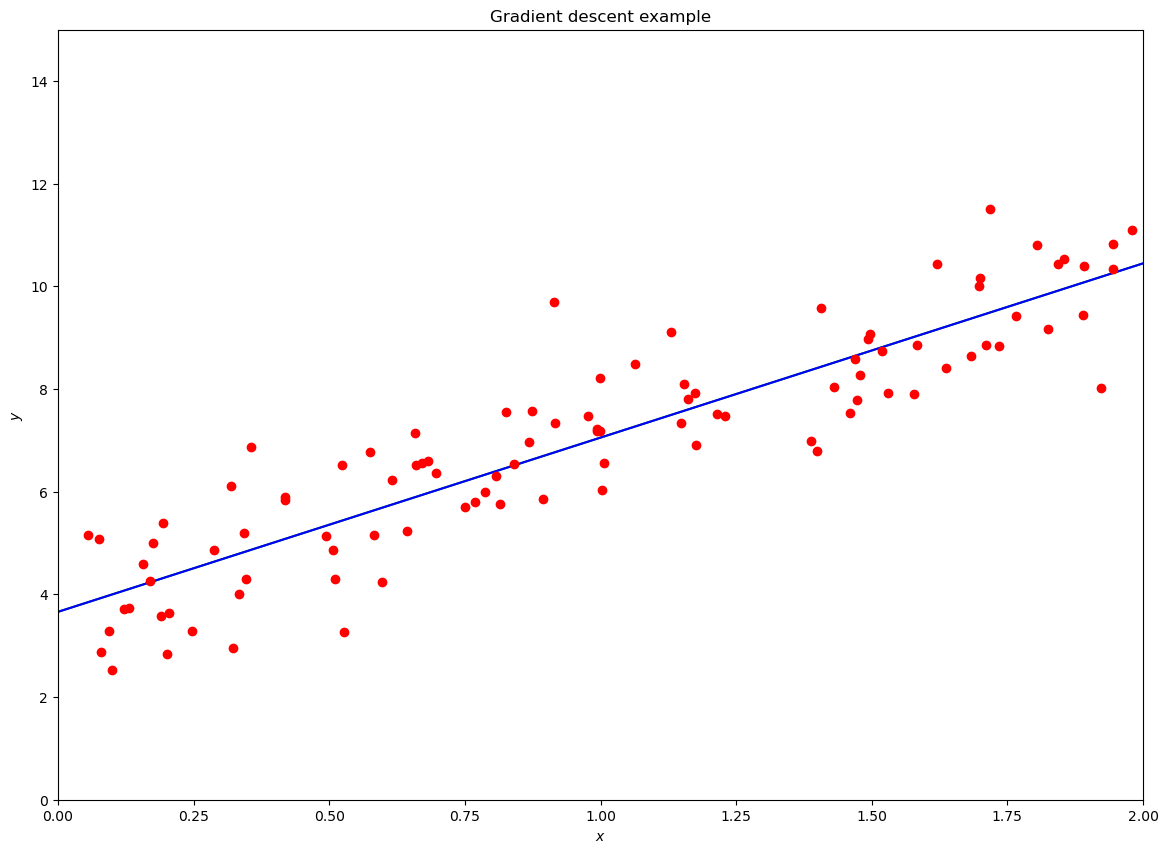

In [28]:

# Importing various packages
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

# Ns è il numero di campionamenti nel dataset
Ns = 100
x = 2*np.random.rand(Ns,1)
y = 4+3*x+np.random.randn(Ns,1)

# genera la matrice di design
X = np.c_[np.ones((Ns,1)), x]

# matrice Hessiana e autovalori
H = (2.0/Ns)* X.T @ X
# Get the eigenvalues
EigValues, EigVectors = np.linalg.eig(H)
print("Gli autovalori della matrice Hessiana sono: ",EigValues)

# learning rate
eta = 1.0/np.max(EigValues)
print("La velocità di apprendimento è fissata a: ",eta)


# Soluzione esatta
beta_linreg = np.linalg.inv(X.T @ X) @ X.T @ y
print("I valori ottimali dei beta_i (calcolati analiticamente) sono: ",beta_linreg)


#
#  Qui inizia l'algoritmo di GD
#
beta = np.random.randn(2,1)
Niterations = 1000
#
for iter in range(Niterations):
    gradient = (2.0/Ns)*X.T @ (X @ beta-y)
    beta -= eta*gradient

print("I valori ottimali dei beta_i ottenuti tramite GD sono: ",beta)

#
# Genera una dei risultati 
fig = plt.figure(figsize=(14,10))
xnew = np.array([[0],[2]])
xbnew = np.c_[np.ones((2,1)), xnew]
ypredict = xbnew.dot(beta)
ypredict2 = xbnew.dot(beta_linreg)
plt.plot(xnew, ypredict, 'g-')
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example')
plt.show()

<!-- !split  -->
### Caso di regressione lineare con una regolarizzazione di ridge

L'estensione del modello appena implementato ad una regolarizzazione di ridge (ovvero, limitando la norma $L_2$ di $\boldsymbol{\beta}$) è semplice.
La funzione di costo va aggiornata a

$$
C_{\text{ridge}}(\boldsymbol{\beta}) = \frac{1}{N_S}||\boldsymbol{X}\boldsymbol{\beta} -\vec{y}||^2 + \frac \lambda {N_S}||\boldsymbol{\beta}||^2, \ \lambda \geq 0 \,,
$$

il gradiente diviene

$$
\nabla_\boldsymbol{\beta} C_{\text{ridge}}(\boldsymbol{\beta})  = \frac{2}{N_S}\begin{pmatrix} \sum_{i=1}^{N_S} \left(\beta_0+\beta_1x_i-y_i\right) \\
\sum_{i=1}^{N_S}\left( x_i (\beta_0+\beta_1x_i)-y_ix_i\right) \\
\end{pmatrix} + \frac {2\lambda} {N_S}\begin{pmatrix} \beta_0 \\ \beta_1\end{pmatrix} = \frac{2}{N_S} \left(\boldsymbol{X}^T(\boldsymbol{X}\boldsymbol{\beta} - \vec{y})+\lambda \boldsymbol{\beta} \right) \, ,
$$
mentre la soluzione analitica per il modello ottimale è:

$$
\boldsymbol{\beta}_{\text{ridge}} = \left(\boldsymbol{X}^T \boldsymbol{X} + \lambda I^{2 \times 2} \right)^{-1} \boldsymbol{X}^T \vec{y} \, .
$$

La nuova versione del programma per minimizzare $C_{\text{ridge}}(\beta)$ con l'algoritmo di discesa dal gradiente è come segue:


[[0.002 0.   ]
 [0.    0.002]]
I valori ottimali dei beta_i (calcolati analiticamente) sono:  [[3.84757078]
 [3.15076332]]
I valori ottimali dei beta_i ottenuti tramite GD sono:  [[3.59967502]
 [3.33639023]]


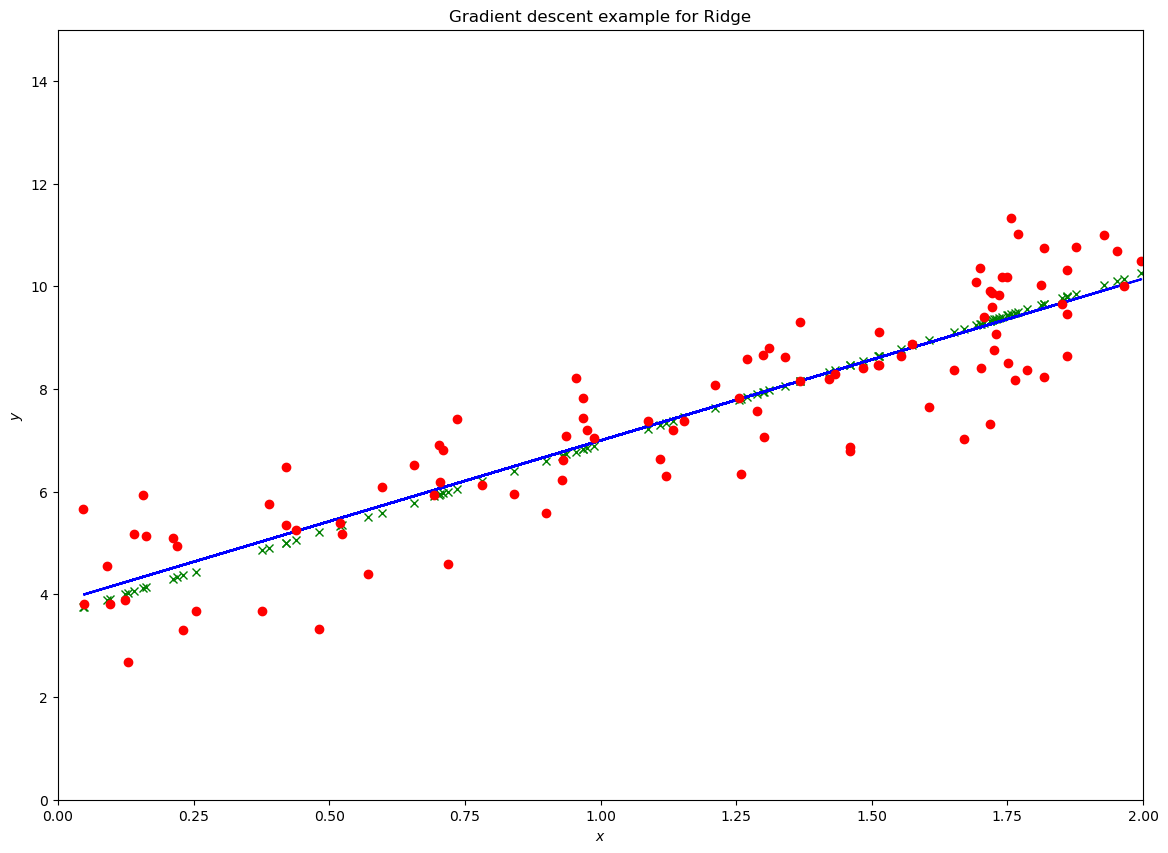

In [8]:
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys

# Ns è numero di punti campionati
N_S = 100
x = 2*np.random.rand(N_S,1)
y = 4+3*x+np.random.randn(N_S,1)

# Matrice di design
X = np.c_[np.ones((N_S,1)), x]
XT_X = X.T @ X

# Paramtro di Ridge, lambda
lmbda  = 0.002
Id = lmbda* np.eye(XT_X.shape[0])
print(Id)

beta_linreg = np.linalg.inv(XT_X+Id) @ X.T @ y
print("I valori ottimali dei beta_i (calcolati analiticamente) sono: ",beta_linreg)


# Start plain gradient descent
beta = np.random.randn(2,1)
#
eta = 0.1
Niterations = 15
#
for iter in range(Niterations):
    gradients = (2.0/Ns)* X.T @ (X @ beta - y) + (2.0/Ns)*lmbda*beta
    beta -= eta*gradients

print("I valori ottimali dei beta_i ottenuti tramite GD sono: ",beta)

#
# Genera una figura dei risultati 
fig = plt.figure(figsize=(14,10))
ypredict = X @ beta
ypredict2 = X @ beta_linreg
plt.plot(x, ypredict, "gx")
plt.plot(x, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient descent example for Ridge')
plt.show()

### Limitazioni della discesa (semplice) del gradiente

* **La discesa del gradiente (GD) converge verso minimi locali di una funzione**. Poiché l'algoritmo GD è deterministico, se converge, raggiunge un minimo locale della funzione di costo (e non necessariamente quello globale). In ML si ha spesso a che fare con suprefici molto accidentate e con molti minimi, questo può portare a risultati di scarsa qualità.

* **La GD è sensibile alle condizioni iniziali**. L'importanza delle condizioni iniziali in GD è conseguenza diretta della natura locale dell'algoritmo: in funzione del punto di partenza si raggiungono minimi locali differente e quindi divente molto importante pensare a come va inizializzato il processo di allenamento. Queso vale anche per le varianti più sofisticate dell'algoritmo di GD (semplice).

* **Il calcolo dei gradienti diventa molto costoso, in termini di risorse di calcolo, per insiemi di dati molto grandi**. In molte applicazioni statistiche o di ML, la funzione di costo si riduce ad una somma di contributi che vanno valutati separatamente per ogni dato.  Per esempio, la regressione lineare usa OLSs $C \propto \sum_{i=1}^{N_S} (y_i - \boldsymbol{\beta}^T \boldsymbol{x}_i)^2$ mentre la regressione logistica usa l'entropia incrociata. Il calcolo preciso del gradiente richiede una somma su *tutti* gli $N_S$ punti e ripetere questa operazione ad ogni passo può rallentare considerevolmente l'esecuzione del codice. Una possibile soluzione è quella di calcolare i gradienti usando solo _piccoli sottoinsiemi_ dei dati (in inglese denominati "_mini batch_", ovvero '_lotti_'). Questo ha il beneficio di introdurre elementi stocastici nell'algoritmo (si veda sotto).

* **La GD è molto sensibile alla scelta della velocità di apprendimento**. Se l'apprendimento è molto lento il processo di minimizzazione può richiedere tempi molto lunghi (anche proibitivi) mentre apprendimenti troppo veloci fanno divergere la GD. Non è raro dover adattare la scelta della velocità di apprendimento in funzione dell'andamento locale della funzione di costo. 

* **La GD tratta tutte le direzioni nello spazio dei parametri in modo uniforme**. Un'altro importante difetto è che la GD non usa informazioni sulla curvature della superficie (differentemente dal metodo di Newton) ed spesso si usa la stessa velocità di apprendimento in tutte le direzioni. Per questo motivo, si impone un valore massimo che viene imposto dalla direzzione di maggior curvatura (si ricordi che $\gamma \leq 1/\lambda_{\rm max}$). Sarebbe uaspicabile porter utilizzare passi larghi in direzioni in cui la superficie è pressoché piana e piccoli passi in direzioni in cui è ripida. Per far ciò è necessario conoscere la curvatura della superficie, ovvero calcolarne le derivate seconde. Idealmente questa informazione è contenuta nell matrice Hessiana che però è molto costosa da calcolare ad ogni passo.

* La GD può richiedere tempi esponenzialmente lunghi per passare attraverso punti di sella anche inizializzando casualmente i parametri. Come menzionato sopra, la GD è molto sensibile alle condizioni iniziali perché queste determinano il minimo locale che vienre poi raggiunto. Purtroppo anche con un buon metodo si inizializzazione e includendo elementi di stocasticiotà, la GD può semre richiedere tempi espoenezialmente lunghi per sfuggire a punti di sella.


<!-- !split  -->
## Discesa stocastica del gradiente

La discesa stocastica del gradiente (SGD) e le sue varianti risolvono alcune delle limitazioni della GD semplice discusse sopra.

L'idea di base di SGD viene dall'osservazione che la funzione di costo può essere sempre scritta come somma sugli $N_S$ putni inclusi nel dataset di apprendimento, $\{\boldsymbol{x}_i\}_{i=1}^{N_S}$:
$$
C(\boldsymbol{\beta}) = \sum_{i=1}^{N_S} \ell_i(\boldsymbol{x}_i,
\boldsymbol{\beta}) \, .
$$
Questo a sua volta signigica che anche il gradiente diventa unna somma si contributi parziali:
$$
\nabla_\boldsymbol{\beta} \, C(\boldsymbol{\beta}) = \sum_i^{N_S} \nabla_\boldsymbol{\beta} \, \ell_i(\boldsymbol{x}_i,
\boldsymbol{\beta}).
$$

È possibile introdurre elementi di stocasticità limitando tali somme a sotto insiemi 
casuali chiamati _lotti_ (in inglese, '_mini batches_'). Se abbiamo $N_S$ punti in totale e 
scegliamo dei sottoinsiemi di $N_B$ punti ciascuno avremo $B=N_S/N_B$ lotti in totale.
Di seguito, useremo $B_k$ per indicare i lotti dove $k=1,\cdots,B$.

### Esempio di SGD
Supponiamo di avere $10$ dati in totale $(\boldsymbol{x}_1,\cdots, \boldsymbol{x}_{10})$ 
e di suddividerli in $B=5$ lotti. Ogni lotto conterrè due punti.
then each minibatch contains two data points.
Per esempio, potremmo avere
$B_1 = (\boldsymbol{x}_1,\boldsymbol{x}_2), \cdots, B_5 =
(\boldsymbol{x}_9,\boldsymbol{x}_{10})$.

Si noti che la scelta $B=1$ (e quindi $N_B=N_S$) corrisponde ad avere
un solo lotto contenente tutti i dati per l'allenamento. In questo caso
ci si riduce alla GD semplice che per questo motivo viene anche chiamata
'_discesa del gradiente su tutti i dati_' ('_Batch Gradient Descent_' in inglese).
Il caso opposto quell in cui $B=N_S$ ($N_B=1$) e si ha un lotto per per ogni
singlolo dato, ovvero $B_k = \boldsymbol{x}_k$. Normalmente, quando si parla di
_discesa stocastica del gradiente_ (senza indicare '_mini batch_' o '_a lotti_')
si intente $B=N_S$.

L'idea di base di SGD, in tutte le sue forme, è quella di approssimare
il gradiente rimpiazzando la somma sull'intero set di dati con un solo 
lotto (un sottoinsieme di tutti i dati) che viene scelto a caso ad ogno
nuovo passo di ottimizzazione:

$$
\nabla_{\boldsymbol{\beta}}
C(\boldsymbol{\beta}) = \sum_{i=1}^{N_S} \nabla_\boldsymbol{\beta} \, \ell_i(\boldsymbol{x}_i,
\boldsymbol{\beta}) 
\rightarrow
\sum_{i \in B_k}^{N_B} \nabla_\boldsymbol{\beta} \, \ell_i(\boldsymbol{x}_i, \boldsymbol{\beta}).
$$

Quindi, il *passo di discesa del gradiente* diventa

$$
\boldsymbol{\beta}_{j+1} = \boldsymbol{\beta}_j - \gamma_j \sum_{i \in B_k}^{N_B} \nabla_\boldsymbol{\beta} \, \ell_i(\boldsymbol{x}_i,
\boldsymbol{\beta})
$$

dove $k$ ($\in\mathbb{N}$) viene scelto casualmente e con probabilità uniforme
nell'intervallo $[1,B]$. Una sequenza di passi pari al numero di lotti 
($B=N_S/N_B$) corrisponde ad avder usato $N_S$ dati e viene comunqmente 
chiamata '_epoca_'. Generalmente si ragiona in termini di epoche e per
ognuna di queste si itera su un set di lotti come mostrato dalle schema
seguente.

Questo è un primo **schema del codice di SGD**:

In [29]:
import numpy as np 

Ns = 100 #100 datapoints 
Nb = 5   #size of each minibatch
B = int(Ns/Nb) #number of minibatches
N_epochs = 10 #number of epochs

j = 0
for epoch in range(1,N_epochs+1):
    for i in range(B):
        k = np.random.randint(B) #Pick the k-th minibatch at random
        #Compute the gradient using the data in minibatch Bk
        #Compute the new minimization step
        j += 1


Calcolare il gradiente solamente su un sottoinsieme dei dati comporta
due benefici importanti. Per prima cosa, introduce un elemento di 
stocasticità con l'effetto di ridurre le possibilità che l'ottimizzazione
rimanga bloccata in un minimo locale. Il secondo beneficio è che se
la dimensione dei lotti è sensibilmente minore del set di dati
completo ($N_B <  N_S$), il calcolo del gradiente richiede un tempo
minore perché non è più necessario sommare su tutti gli $N_S$ punti.

### Interruzione della discesa e scelta della velocità di apprendimento

È necessaron decidere a che punto fermare l'algoritmo per
la ricerca del minimo. Una possibilità sarebbe quella di calcolare 
il gradiente completo dopo un certo numero di epoche e fermarsi se
la sua norma scende sotto una certa soglia (simile a controllare se i
passi diventano sufficientemente piccoli). Tuttavia la condizione di
gradiente nullo è valida anche per i miniumi locali, quindi questa
procedura ci dice solo che siamo vicini ad un minimo senza dirci 
se sia globale o meno.  Un altro approccio è quello di calcolare e
salvare ca funzione di costo alla fine di ogni epoca per controllare
continui a diminuire. Se ad un certo punto si trova un incremento, si 
può sempre ripartire dei parametri $\boldsymbol{\beta}$ dell'epoca
precedente.

Un altro dettaglio importante è far sì che la velocità di apprendimanto
$\gamma_j$ possa variare col numbero di epoche in modo da diminuire
e diventare piccola dopo un un certo tempo, in modo da fermare gradualmente 
il percorso stocastico. Questo processo corrisponde e congelare
adiabaticamente lo statto del sistema in per intrappolarlo nel minimo
locale.

Per esempio, si consideri la sequenza di epoche, indicizzate con $e = 0,1,2,3,\cdots$,
e due parametri $t_0, t_1 > 0$ fissati. Se $i=0,\cdots,B-1$ indica la sequanza di lotti 
all'epoca $e$, allora $t = e \cdot B + i$ è il numero totale di passi fatti fino a quel
momento. La funzione
$$
\gamma_j(t; t_0, t_1) = \frac{t_0}{t+t_1}
$$
produce una lunghezza di apprendimento iniziale peri a $\gamma_j (0; t_0, t_1) = t_0/t_1$
poi decade verso lo zero man mano che aumentalo le iterazioni. Il parametro $t_1$ fissa
la scala 'temporale' per il suo dimezzamento.
Un'altra possibilità usata frequentemente è
$$
 \gamma_j(t; t_0, t_1) = \frac{t_0} {\sqrt{t+t_1}} \,.
$$


In [30]:
import numpy as np 

def step_length(t,t0,t1):
    return t0/(t+t1)

Ns = 100 #100 datapoints 
Nb = 5   #size of each minibatch
B = int(Ns/Nb) #number of minibatches
N_epochs = 10 #number of epochs
t0 = 1.0
t1 = 10

gamma_j = t0/t1
j = 0
for epoch in range(1,N_epochs+1):
    for i in range(B):
        k = np.random.randint(B) #Pick the k-th minibatch at random
        #Compute the gradient using the data in minibatch Bk
        #Compute new suggestion for beta
        t = epoch*B+i
        gamma_j = step_length(t,t0,t1)
        j += 1

print("gamma_j after %d epochs: %g" % (N_epochs,gamma_j))

gamma_j after 10 epochs: 0.00436681


### Programma finale per la discesa stocastica del gradiente

Qui di seguito riportiamo il il codice completo per risolvere il nostro problema di regressione lineare usando l'algoritmo di SGD e confrontarlo con il risultato dell minimizzazione esatta. Si noti che la minimizzazione viene effettuata in diversi modi:

* Usando la GD semplice, come negli esempi visti in precedenza.

* Implementando SGD a mano, secondo l'algoritmo appena descritto.

* Usando il metodo '**sklearn.linear_model.SGDRegressor**' che implementa la SGD direttamente. È importante tenere a mente questa funzione e studiarne le opzioni sulla socumentazione di *SciKit Learn*, in modo da potertla usare in problemi più complessi.


 Inversione esatta: [[4.01204874]
 [2.92606244]]

 Calcolo SGD usando SciKit Learn con  8  epoche : [3.83867516] [2.85956064]

 Calcolo SGD usando SciKit Learn con  8  epoche : [[3.8386751621868793], [2.8595606379519847]]

 Calcolo GD semplice usando  50  iterazioni : [[3.812194  ]
 [3.10158079]]

 Calcolo usando il nostro codice SGD con  8  epoche : [[3.8746692 ]
 [3.09650188]]


/opt/homebrew/Caskroom/miniconda/base/envs/jupyter/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:1616: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


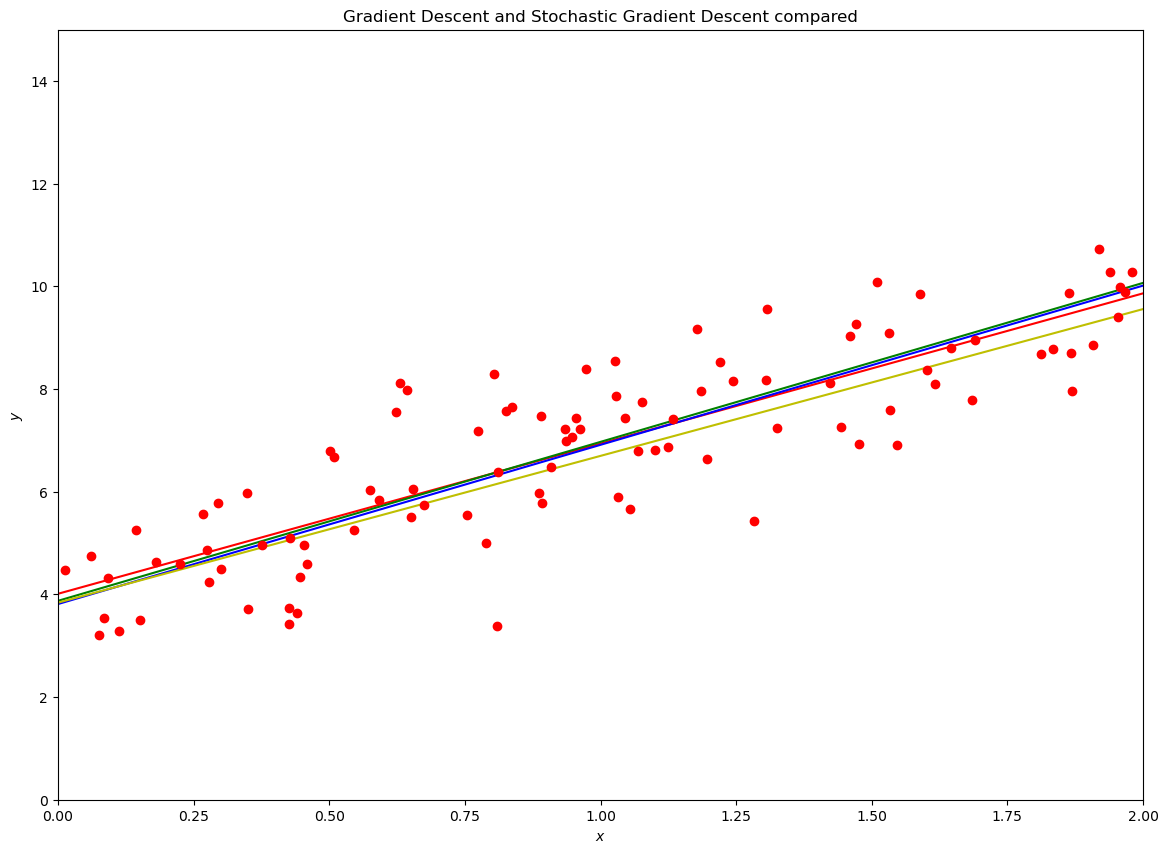

In [33]:
# Importing various packages
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

# Creazione dataset
Ns = 100
x = 2*np.random.rand(Ns,1)
y = 4+3*x+np.random.randn(Ns,1)


# soluzione analitica
X = np.c_[np.ones((Ns,1)), x]
beta_linreg = np.linalg.inv(X.T @ X) @ (X.T @ y)
print("\n Inversione esatta:",beta_linreg)


# 
# Parametri per la GD e SGD:
Niterations = 50  # per GD
N_epochs = 8       # per SGD
#NOTA: N_epochs>30 converge in questo caso, si provi anche un valore piccolo per vedere
# il comportamento durante le iterazioni
eta=0.1
Nb = 5   #size of each minibatch
M = int(Ns/Nb) #number of minibatches


#
# Usando SGD da SciKit Learn:
sgdreg = SGDRegressor(max_iter = N_epochs, penalty=None, eta0=eta)
sgdreg.fit(x,y.ravel())
print("\n Calcolo SGD usando SciKit Learn con ",N_epochs," epoche :",sgdreg.intercept_, sgdreg.coef_)
beta_skl = np.random.randn(2,1)
beta_skl = ([[sgdreg.intercept_[0]], [sgdreg.coef_[0]]])
print("\n Calcolo SGD usando SciKit Learn con ",N_epochs," epoche :",beta_skl)

#
#  Algoritmo di GD semplice
#
beta_gd = np.random.randn(2,1)
for iter in range(Niterations):
    gradients = 2.0/Ns*X.T @ ((X @ beta_gd)-y)
    beta_gd -= eta*gradients
print("\n Calcolo GD semplice usando ",Niterations," iterazioni :",beta_gd)


#
#  Algoritmo di SGD
#

t0, t1 = 5, 50
def learning_schedule(t):
    return t0/(t+t1)

beta_sgd = np.random.randn(2,1)

for epoch in range(N_epochs):
    for i in range(M):
        random_index = Nb * np.random.randint(M)
        xi = X[random_index:random_index+Nb]
        yi = y[random_index:random_index+Nb]
        gradients = 2 * xi.T @ ((xi @ beta_sgd)-yi)
        eta = learning_schedule(epoch*M+i)
        beta_sgd = beta_sgd - eta*gradients
print("\n Calcolo usando il nostro codice SGD con ",N_epochs," epoche :",beta_sgd)


#
# Si ricalcolano le predizino per gli estremi,  x=0 e 2,
# per fare poi un grafico
xnew = np.array([[0],[2]])
Xnew = np.c_[np.ones((2,1)), xnew]
ypredict_lr  = Xnew.dot(beta_linreg)
ypredict_gd  = Xnew.dot(beta_gd)
ypredict_sgd = Xnew.dot(beta_sgd)
ypredict_skl = Xnew.dot(beta_skl)



#
# Genera una figura coi risultati 
fig = plt.figure(figsize=(14,10))
plt.plot(xnew, ypredict_lr , "r-")
plt.plot(xnew, ypredict_gd , "b-")
plt.plot(xnew, ypredict_sgd, "g-")
plt.plot(xnew, ypredict_skl, "y-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Gradient Descent and Stochastic Gradient Descent compared')
plt.show()

#### Esercizi: 
+ Si provi ad implementare gli esempi di cui sopra per na funzoine non convessa (file '**Esempi_Minimizzazione.ipynb**').
+ Si provi a scrivere un codice simile pwer il caso di Regressione Logistica (ovvero usande l'*entropia incrociata* o *IRLS*).

---

-- --

## Metodi di ottimizzazione della velocità di apprendimento e delle iterazioni

Qui di seguito elenchiamo le strategie più comuni usate per controllare la l'apprendimando nei metodi GD e SGD. Una discussione più approfondita è data nell'articolo di [Ruder (arXiv:1609.04747)](https://arxiv.org/abs/1609.04747v2).

### Metodo del momenti (Momentum based GD)

Nella discesa stocastica del gradiente (SGD) si usa molto spesso un termine di *momento*
al fine di dare una inerzia al percorso di ottimizzazione nello spazio dei parametri.
In sostanza si tiene memoeria della direzione in cui ci si ta muovendo al fine di minimizzare
eventuali `sbandate' se ci sono delle fluttuazioni improvvise del gradiente
tra passi successivi.

Una implementazione tipica è la seguente:

$$
\mathbf{v}_{t}=\gamma \mathbf{v}_{t-1}-\eta_{t}\nabla_\theta E(\boldsymbol{\theta}_t) \nonumber
$$

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_t +\mathbf{v}_{t},
$$



dove abbiamo introdotto un parametro di momento (o ti _inerzia_) $\gamma$, con
$0\le\gamma\le 1$, e rimane sotto inteso che il gradiente è calcolato 
ad ogni passo su un solo campionamento (in caso di SGD puro) oppure
su un mini-batch (per mb-SGD).
Questo algoritmo viene chiamato _gradient descent with momentum
(GDM)_. 
Dall'equazione sopra si vede che la velocità nello spazio dei
paramteri, $\mathbf{v}_t$ è una media aggiornata degli ultimi gradienti 
incontrati mentre 
$(1-\gamma)^{-1}$ può essere interpretata come una scala temporale caratterisitca
e quindi controlla la durata della 'memoria' per il calcolo della media.
Ovviamente, quando $\gamma=0$ l'algoritmo si riduce al semplice SGD già discusso.

In maniera equivalente, gli aggiornamenti possono anche essere scritti in funzione del passo:

$$
\Delta \boldsymbol{\theta}_{t+1} = \gamma \Delta \boldsymbol{\theta}_t -\ \eta_{t}\nabla_\theta E(\boldsymbol{\theta}_t),
$$

dove $\Delta \boldsymbol{\theta}_{t}\equiv \boldsymbol{\theta}_t-\boldsymbol{\theta}_{t-1}$.



#### Più dettagli sul metodo del momento

Le equazioni appena discusse possono essere spiegate più intuitivamente con un 
analogo di meccanica.
Consideriamo una particella si massa $m$ che si muove in un mezzo viscoso
con coefficiente di attrito dinamico $\mu$ ed con una energia potenziale
$E(\mathbf{w})$. Se indichiamo il vettore posizione della particella con $\mathbf{w}$,
abbiamo:


$$
m {d^2 \mathbf{w} \over dt^2} + \mu {d \mathbf{w} \over dt }= -\nabla_w E(\mathbf{w}).
$$

Discretizziamo le derivate su un intervallo di tempo $ \Delta t$,

$$
m { \mathbf{w}_{t+\Delta t}-2 \mathbf{w}_{t} +\mathbf{w}_{t-\Delta t} \over (\Delta t)^2}+\mu {\mathbf{w}_{t+\Delta t}- \mathbf{w}_{t} \over \Delta t} = -\nabla_w E(\mathbf{w}) ,
$$

E riarrangiamo l'equazione come:

$$
\Delta \mathbf{w}_{t +\Delta t}= - { (\Delta t)^2 \over m +\mu \Delta t} \nabla_w E(\mathbf{w})+ {m \over m +\mu \Delta t} \Delta \mathbf{w}_t.
$$

#### Parametro del momento

L'ultima equazione è identica a quella del metodo GDM se identifichiamo
la posisione della particlella, $\mathbf{w}$, come la posizione nello
soazio dei parametri $\boldsymbol{\theta}$.
Questo ci permette di relazionare il parametro di momento e la velocità
di apprendimento alla massa della particella ed al coefficienti di attrito:

$$
\gamma= {m \over m +\mu \Delta t }, \qquad \eta = {(\Delta t)^2 \over m +\mu \Delta t}.
$$

Il parametro di 'momento' $\gamma$ tende a zero nel limite in cui la massa
è trascurabile e l'attirto viscoso è dominante, mentre $\gamma\rightarrow1$
per $m\gg\mu\Delta t$. Quindi $\gamma$ misura l'importanta del temrine di
inerzia e la SGD standard (i.e., senza temrina di momento) corrisponde al
moto in un mezzo infinitamente viscoso.

_Perché il termine dimometo è utile?_ 
GDM aiuta il metodo do SGD a prendere più velocità nelle direzoni in 
cui il i gradienti sono piccoli ma persistenti anche in presenza di
fluttuazioni stocastiche, menter al tempo stesso sopprime le oscillazioni
in direzioni con grandi curvature.
Questo diventa particloarmente importante in situazioni in cui al superficie
da minimizzare e poco profinda o piatta in alcune direzione mentre prasenta
dei brevi tratti ripidi in altre direzioni.
In certi casi metodi al primo ordine (ovvero lineari nel momento) possono 
funzionare efficientemente e al pari di metodi più costi al secondo ordine,
con scelte appropriate delle condizioni iniziali. Si ritiene che questo sia
il caso per modelli di apprendimento molto complessi e profondi.




I vantaggi del metodo del momento sono a volte amplificati usando una
semplice variante dell'alcoritmo classico denominata _Nesterov Accelerated Gradient (NAG)_:



In NAG , invece di calcolare passo successivo usando i parametri correnti, $\nabla_\theta E(\boldsymbol{\theta}_t)$, 
si valuta il gradiente al punto in cui ci si aspetterebb di arrivera dato 
il valore corrente del momento, $\nabla_\theta E(\boldsymbol{\theta}_t +\gamma
\mathbf{v}_{t-1})$. Quindi, la regola di aggiornamento NAG diventa


In the NAG algorithm, rather than calculating the gradient at the
current parameters, $\nabla_\theta E(\boldsymbol{\theta}_t)$, one
calculates the gradient at the expected value of the parameters given
our current momentum, $\nabla_\theta E(\boldsymbol{\theta}_t +\gamma
\mathbf{v}_{t-1})$. This yields the NAG update rule

$$
\mathbf{v}_{t}=\gamma \mathbf{v}_{t-1}+\eta_{t}\nabla_\theta E(\boldsymbol{\theta}_t +\gamma \mathbf{v}_{t-1}) \nonumber
$$

$$
\boldsymbol{\theta}_{t+1}= \boldsymbol{\theta}_t -\mathbf{v}_{t}.
$$

Uno dei vantaggi maggiori di NAG è quello di permettere l'uso di velocità di apprendimento più grandi che per il GDM,a parità di scelta di $\gamma$.



## Momento di ordine due del gradiente

Nella discesa stocastica del gradiente, con e senza momento, rimane il 
problema di schegliere un procedimento per calibrare la velocità di
apprendimento $\eta_t$ con l'evolvere del tempo.
Come discusso in relazione al metodo ni Newton, queto presente alcune 
problematiche. La velocità di apprendimento (se isotropa in tutte le 
direzione di ${\bf \theta}$) deve essere limitata dalla curvatura nella
direzione più ripida, la quale può cambiare muovendosi nello spazio
dei parametri. Per aggirare il problema si potrebbe monitorare
la curvatura, facendo passi lunghi in direzioni ove si hanno avvallamenti
dolci o pianegginti e passi più corti in direzioni di curvatura maggiore.
I metodi al secondo ordine seguono questo approccio calcolando o approssimando
la matrice Hessiana e usandola per normalizzare la velocità di apprendimento.
Tuttavia quaesto approccio diventa computazionalmente costoso per sistemi 
di grandi dimensioni.
Idealmente, vorremmo essere in grado di cambiare la lunghezza del passo
ad ogni iterazione in funzione dell'andamento della superficie senza però
dover incorrere nei costi computazionali di calcolare o approssimare
l'Hessiana.

Alcuni approcci introdocci in gnegli anni recenti permettono di far ciò 
tenendo traccia non solo del gradiente (ovvero il
momento o velocità) ma anche del secondo momento di della distribuzione
del gradiente (ovvero il quadrato delle velocità). Alcuni di questi
metodi sono _AdaGrad_, _RMS-Prop_, e _ADAM_.


### AdaGrad

AdaGrad sta per "_adaptive gradient algorithm_". In breve mira a ridurre la velocità di apprendimento $\eta$ più velocemente nelle direzioni dello spazio dei parametri in cui i gradienti sono molto elevati, in modo da evitare instabilità, mentre la riduzione di $\eta$ è più lenta ove i gradienti sono piccoli e quindi dove è necessario fare passi più lunghi.
Se $${\bf g}_\tau \equiv \nabla E(\boldsymbol{\theta}_t)$$ è il gradiente allora si va a guardare la somma cumulativa dei quadrati dei gradienti in ogni direzzione

$$
 G_j = \sum_{\tau=1}^{t} {\bf g}_{\tau,i}
$$

dove $i$ indica la i-esima componente del vettore.
Ad ogni passo, i parametri del modello sono aggiornati in modo inversamente proporzionale alla norma $\ell_2$ dei gradienti:

$$
 \boldsymbol{\theta}_{t+1,i}=\boldsymbol{\theta}_{t,i} - \frac{\eta}{\sqrt{G_j + \epsilon}} \,{\bf g}_{\tau,i}  \qquad  \forall \;i \, .
$$

Il parametro $\eta$ rimane invariato durante tutto l'allenamento, tuttafiva viene ad aogni volta ridotto per la norma $\ell_2$ dei gradienti $\left(\sqrt{G_j} = \sqrt{\sum_{\tau=1}^{t} {\bf g}_{\tau,i}}\right)$ la quale aumenta ad ogni passo. Il punto cruciale è che la riduzione è calcolata indipendentemente per ogni direzione dello spazio dei parametri. Il parametro $\epsilon$ è scelto molto piccolo e serve ad evitare divisione per zero durante i primi passi.

Valori tipici sono $\eta\approx0.01$ e $\epsilon\approx10^{-8}$. 

### RMS prop

RMS prop sta per "Root Mean Square propagation". L'idea è quella di ridurre il passo in ogni direzione in maniera inversamente proporzionale alla velocità nello spazio dei parametri ma, invece di vare una somma cumulativa di tutti i gradienti precedenti, si considerano solo i passi più recenti. Invece di mantenre una media corrente del gradiente (come per il momento) consideriamo la media del quadrato delle velocità $\mathbf{s}_t=\mathbb{E}[\mathbf{g}_t^2]$ che è il memonto di ordine 2 della distribuzione.
La regola di aggiornamento per RMS prop è data da

$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) 
$$

$$
\mathbf{s}_t =\beta \mathbf{s}_{t-1} +(1-\beta)\mathbf{g}_t^2 \nonumber
$$

$$
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t - \eta_t { \mathbf{g}_t \over \sqrt{\mathbf{s}_t +\epsilon}}, \nonumber
$$

dove $\beta$ controlla l'intervallo di 'tempo' su cui si calcola la media corrente e tipicamente a valori intorno a $\beta=0.9$, $\eta_t$ è la velocità di apprendimento con valori dell'ordine di $10^{-3}$, e $\epsilon\sim 10^{-8} $ è una piccola costante di regolarizzazione usata per prevenire divergenze.

Come per *AdaGrad*,  le moltiplicazioni e divisioni per i vettori descritte sopre _sono intese fatte indipendentemente elemento per elemento_.
 Chiaramente la velocità di apprendimento viene ridotta in direzioni dove il gradiente è consistentemente grande. Questo accelera notevolmente la convergenza ad un minimo, permettendo di usare velocità di apprendimento $\eta$ molto più grandi in direzioni in cui la superficie è particolarmente piatta.



## Ottimizzazione ADAM 

L'algoritmo di ADAM (_Adaptative Moment Estimation_) combina i vantaggi del metodo del *momento* e di *RMSProp*.
In ADAM si mantiene una medie corrente sia del primo che del secondo momenti del gradiente (ovvero la velocità nello psazio dei paramtri ed il suo quadrato) e si usano queste informazioni per adattare la velocità di apprendimento indipendente mente per ogni parametro.
Oltra a mantenere la media corrente delle componenti del gragiente e dei loro quadrati (ovvero, $\mathbf{m}_t=\mathbb{E}[\mathbf{g}_t]$ e $\mathbf{s}_t=\mathbb{E}[\mathbf{g}^2_t]$), ADAM
fa delle correzioni di bias per tenere in conto il fatto che si stanno stimando questi valori usando una media corrente (i valori corretti sono indicati con un cappuccio qui sotto).

Le regole di aggiornamento di ADAM sono le seguanti (dove ancora una volta è sottointeso che si applicano separatemente ai vari elementi di ciascun vettore):

$$
\mathbf{g}_t = \nabla_\theta E(\boldsymbol{\theta}) 
$$

$$
\mathbf{m}_t = \beta_1 \mathbf{m}_{t-1} + (1-\beta_1) \mathbf{g}_t \nonumber
$$

$$
\mathbf{s}_t =\beta_2 \mathbf{s}_{t-1} +(1-\beta_2)\mathbf{g}_t^2 \nonumber
$$

$$
\hat{\boldsymbol{\mathbf{m}}}_t={\mathbf{m}_t \over 1-(\beta_1)^t} \nonumber
$$

$$
\hat{\boldsymbol{\mathbf{s}}}_t ={\mathbf{s}_t \over1-(\beta_2)^t} \nonumber
$$

$$
\boldsymbol{\theta}_{t+1}=\boldsymbol{\theta}_t - \eta_t { \hat{\boldsymbol{\mathbf{m}}}_t \over \sqrt{\hat{\boldsymbol{\mathbf{s}}}_t} +\epsilon}, \nonumber
$$

dobe $\beta_1$ e $\beta_2$ contrillano la scale temporali su cui si calcolano
le medie correnti del primo e secondo momento del gradiente e hanno tipocamente
valori vicini a $0.9$ e $0.99$, rispettivamente. La $\eta$ e $\epsilon$ sono identiche a RMSprop.

Come per RMSprop, la lunghezza effettiva del passodipende dalla grandezza del
gradiente al quadrato. Per vedere questo punto più in dettaglio, riscriviamo questo
termine in funzione della varianza
$\boldsymbol{\sigma}_t^2 = \boldsymbol{\mathbf{s}}_t -
(\boldsymbol{\mathbf{m}}_t)^2$. Preso un parametro $\theta_t$, la regola di aggiornamento diventa:

$$
\Delta \theta_{t+1}= -\eta_t { \boldsymbol{m}_t \over \sqrt{\sigma_t^2 +  m_t^2 }+\epsilon}.
$$

## Consigli pratici

* **Mescolare il dataser quando si creano i mini-batch**. È molto importante rimesolare casualmente l'ordine del set di dati quando si creano dei mini-batche. In caso contrario, la discesa del gradiente potrebbe ottimizzare correlazioni spurie dovute all'ordine in cui i dati sono stati presentei (o campionati).

* **Trasformare i dati di input**. L'ottimizzazione diventa difficile quando la superficie presenta un misto di direzioni con andamenti ripidi e quasi piatti. Un trucco semplice per limitare situazioni simili è quello di standarizzare in dati sonntraendone la loro media e normalizzando la varianza delle variabili in input. Quando è possibile, si dovrebbero rimuovere anche le correlazioni tra i dti ininput. Questo punto può essere compreso semplicemente considerando il caso della regrassione lineare: nel caso di una funzione di costo ai minimi quadreati, si può vedere che la matrice hessiana è data semplicemente dalla matrice di correlazione tra gli input. Quindi, standarizzando le variabili in ingresso si impone che la superficie appaia omogenea in tutt le direzione dello spazio dei parametri. Poiché la maggior parte delle reti neurali profone può essere vista come una serie di trasformazioni lineari (seguite da una non linearità) ad ogni strato, ci si può aspettare che questa spiegazione intuitiva si applichi bene anche a casi più complessi di quello puramente lineare.

* **Monitorare l'andamento sui dati non inclusi nell'allenamento.** Bisogna sempre monitorare l'efficienza del modello un un set di validazione (una piccola porzione dei dati di allenamento che vengono esclusi dal processo di ottimizzazione e usati coem surrogato del dataset di test). Se l'errore di validazione incomincia ad aumentare vuold dire che il modello sta andando in overfitting e quindi il processo di ottimizzazione va terminato. Questo approccio è chiamato *early stopping* e in molti casi migliora notevolmente la performace.

* **Metodi di ottimizzazione adattativi non hanno sempre generalizzazioni efficienti.** Studi recenti hano mostrato che metodi adattativi come ADAM, RMSPorp, e AdaGrad se generalizzati tendono a funzionare peggio dei semplici SGD o SGD col momento, particolarmente nel limite di molte dimensioni (ovvero quando il numero di parametri eccede quello dei dati). Sebbene non sia ancora chiaro perché questi metodi siano così efficienti nell'allenare reti neurali prefonde, procedimenti semplici come un SGD ben calibrato può funzionare altrettanto bene (o meglio) in applicazioni di questo tipo.

Il testo di Geron, al capitolo 11, presenta molte discussioni interessamnti sull'argomento.

L'articolo di [Ruder (arXiv:1609.04747)](https://arxiv.org/abs/1609.04747v2)  dà una introduzione breve ma efficiente del metodo di SGD e delle strategie di ottimizzazione.


---
## Differenziazione automatica

La [differenziazione automatica](https://en.wikipedia.org/wiki/Automatic_differentiation) (_automatic differentiation_, AD),
nota anche come _differenziazione algoritmica_ o _differenziazione computazionale_, è un insieme di tecniche per il calcolo automatico delle derivate di una funzione matematica implementata da un programma informatico. AD, sfrutta il fatto che ogni programma di computer, semplice o complicato che sia, deve eseguire una serie di operazioni aritmetiche elementari (somme, sottrazioni, moltiplicazioni, divisioni, eccc...) o applica delle funzioni elementari (exp, log, sin, cos, etc.). 
Se si applia ripetutamente la regola a catena per la derivata delle funzioni di funzioni a questa sequenza di operazioni, è possibile calcolare automaticamente derivate di ordine arbitrario
I risultati sono accurati, alla precisione numerica della macchina, e usano al masssimo
un poche più operazioni aritmentiche del programma originale.

La differenziazione automatica non è:

* Differenziazione simbolica, né

* Differenziazione numerical (l'approssimazione alla differenze finite ).

La differenziazione simbolica può generare codici inefficienti e presente
difficoltà nel convertire un programma di computer in una espressione aritmetica.
La differenziazione numerica può introdurre errori di numerici dovuti alla
discretizazione e a cancellazioni.

Python ha strumenti per la **differenziazzione automatica**, nel blocco note '**Autograd_e_DifferenziazioneAutomatica.ipynb**' (cartella 'Elementi di Python') si possono trovare esempi dell'uso della libreria *Autograd*.
